## Mask R-CNN - Inspect Custom Trained Model
Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob

# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import custom 

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs9")

custom_WEIGHTS_PATH = "logs9/mask_rcnn_scan_0018.h5" # TODO: update this path

Using TensorFlow backend.


## Configurations


In [2]:
config = custom.CustomConfig()
custom_DIR = os.path.join(ROOT_DIR, "customImages")
test_DIR=os.path.join(custom_DIR, "predict")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Load validation dataset
dataset = custom.CustomDataset()
dataset.load_custom(custom_DIR, "predict")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 5
Classes: ['BG', 'tumor']


In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

W0626 10:19:01.164509 12640 deprecation_wrapper.py:119] From c:\python\python35\lib\site-packages\keras\backend\tensorflow_backend.py:508: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0626 10:19:01.187120 12640 deprecation_wrapper.py:119] From c:\python\python35\lib\site-packages\keras\backend\tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0626 10:19:01.203400 12640 deprecation_wrapper.py:119] From c:\python\python35\lib\site-packages\keras\backend\tensorflow_backend.py:3837: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0626 10:19:01.316887 12640 deprecation_wrapper.py:119] From c:\python\python35\lib\site-packages\keras\backend\tensorflow_backend.py:3661: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0626 10:19:06.808966 12640 deprecation_wrapper.py:119] From c:\python\python35\lib\site-packages\keras

In [8]:
# load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)

Loading weights  logs9/mask_rcnn_scan_0018.h5


In [9]:
from importlib import reload # was constantly changin the visualization, so I decided to reload it instead of notebook
reload(visualize)

<module 'mrcnn.visualize' from 'A:\\c python\\colab mask rcnn\\mrcnn\\visualize.py'>

image ID: scan.yes1_resized.jpg (1) A:\c python\colab mask rcnn\customImages\predict\yes1_resized.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


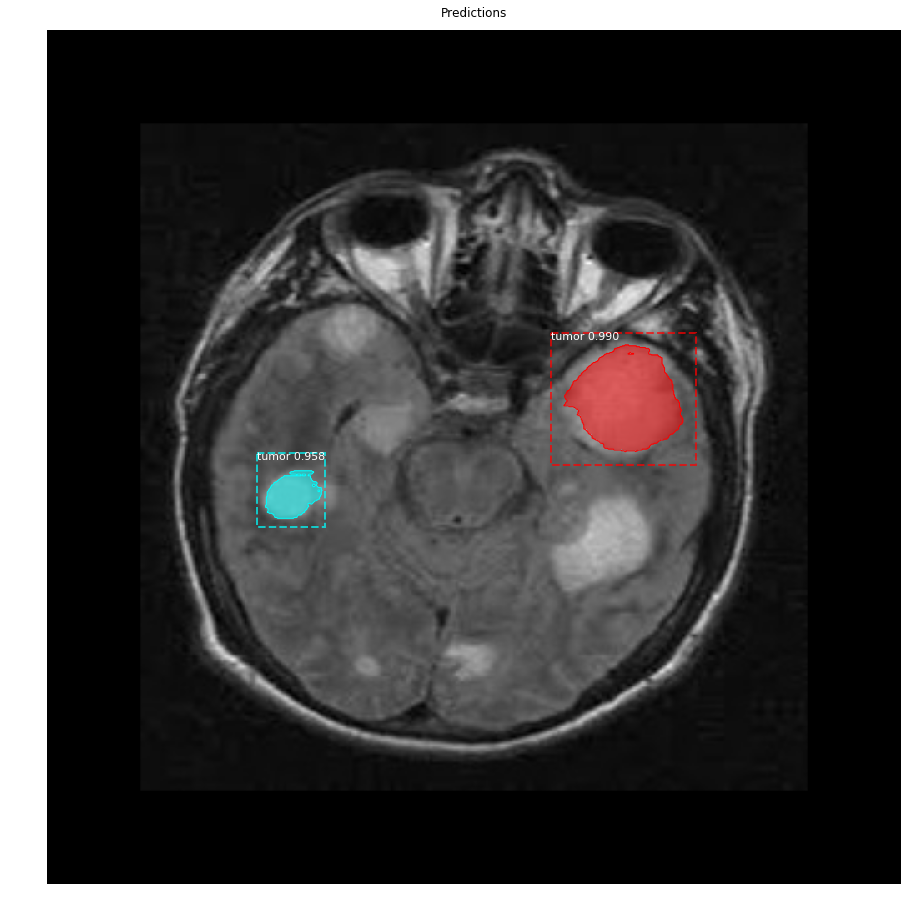

gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:  255.00000  max:  769.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool


In [10]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

image ID: scan.yes3_resized.jpg (3) A:\c python\colab mask rcnn\customImages\predict\yes3_resized.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


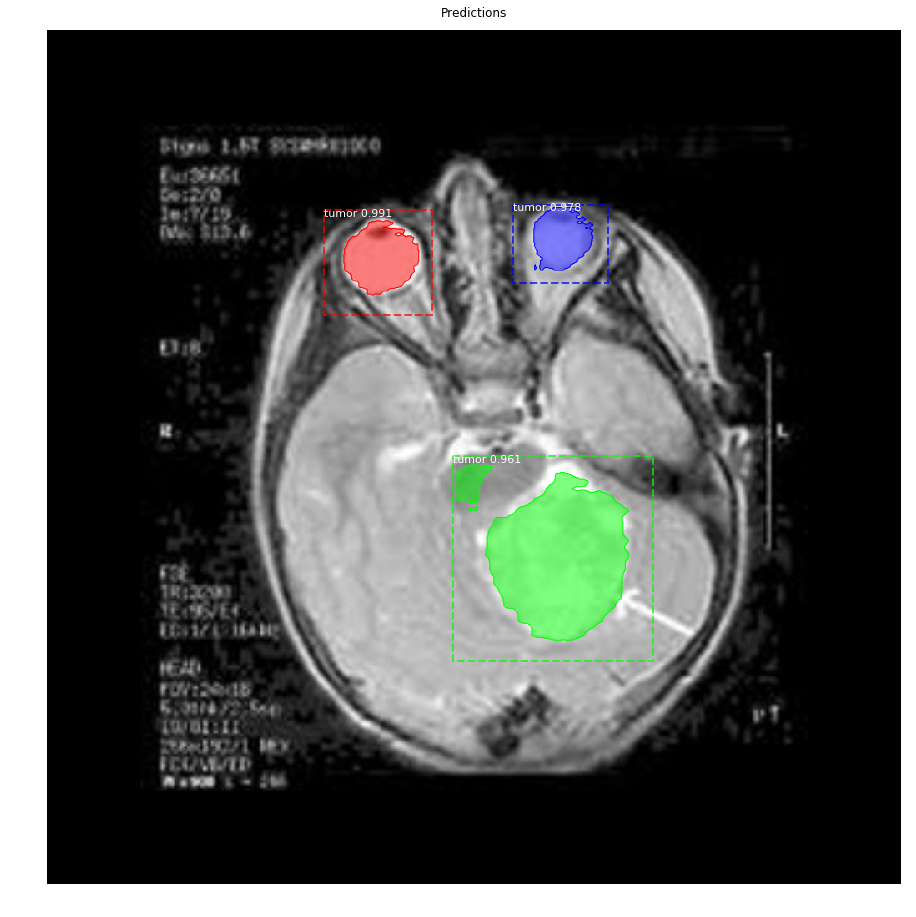

gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  509.00000  max:  741.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


In [16]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)

log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [17]:
#image_id = random.choice(dataset.image_ids)
from glob import glob
file_names = glob(os.path.join(test_DIR, "*.jpg"))
masks_prediction = np.zeros((256, 256, len(file_names)))
for i in range(10):
    print(i)
    image = skimage.io.imread(file_names[i])
    predictions = model.detect([image],  verbose=1)
    p = predictions[0]
    masks = p['masks']
    merged_mask = np.zeros((masks.shape[0], masks.shape[1]))
    for j in range(masks.shape[2]):
        merged_mask[masks[:,:,j]==True] = True
        masks_prediction[:,:,i] = merged_mask
print(masks_prediction.shape)

0
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  139.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
1
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
2
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: 

In [18]:
dataset = custom.CustomDataset()
dataset.load_custom(custom_DIR, "predict")

In [19]:
accuracy = 0
precision = 0
for image_id in range(len(dataset.image_info)):
    name = dataset.image_info[image_id]['id']
    file_name = os.path.join(test_DIR, name)
    image_id_pred = file_names.index(fssile_name)
    merged_mask = masks_prediction[:, :, image_id_pred]
    
    annotated_mask = dataset.load_mask(image_id)[0]
    merged_annotated_mask = np.zeros((256, 256))
    for i in range(annotated_mask.shape[2]):
        merged_annotated_mask[annotated_mask[:,:,i]==True] = True
    accuracy  += np.sum(merged_mask==merged_annotated_mask) / (256 * 256)
    all_correct = np.sum(merged_annotated_mask[merged_mask == 1])
    precision += all_correct / (np.sum(merged_mask))
print('accuracy:{}'.format(accuracy / len(file_names)))
print('precision:{}'.format(precision / len(file_names)))

accuracy:0.4841705322265625
precision:0.3135275113951206
